In [1]:
from glob import glob

#fepoutFiles = glob('your_files_here*.fepout')
#fepoutFiles = ('doubledmp_forward.fepout', 'doubledmp_bakward.fepout')

fepoutFiles_up = ('doubledmp_forward.fepout',)
fepoutFiles_dn = ('doubledmp_bakward.fepout',)

temperature = 300
RT = 0.00198720650096 * temperature

print(f"Will process {len(fepoutFiles_up) + len(fepoutFiles_dn)} fepout files.")

Will process 2 fepout files.


In [2]:
# Arbitrary statistical inefficiency parameter
tau = 5e2 # expected correlation length of series
# used to scale error estimates below, computed assuming uncorrelated data

# Ideally the following would be used instead
# but right now it doesn't seem to work well on IDWS data

# from alchemlyb.preprocessing import subsampling
# u_nk_decorr = subsampling.decorrelate_u_nk(u_nk, method='dE')
# bar_decorr = BAR()
# bar_decorr.fit(u_nk_decorr)

In [3]:
import alchemlyb
from alchemlyb.parsing import namd
from alchemlyb.estimators import BAR
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from alchemlyb.visualisation.dF_state import plot_dF_state

# USER PARAMETERS
plt.rcParams['figure.dpi'] = 150

In [4]:
u_nk_up = namd.extract_u_nk(fepoutFiles_up, temperature)
u_nk_dn = namd.extract_u_nk(fepoutFiles_dn, temperature).sort_index(level=1).sort_index(axis='columns')

u_nk = alchemlyb.concat([u_nk_up, u_nk_dn])

In [5]:
bar = BAR()
bar.fit(u_nk)

BAR()

In [6]:
# Extract data for plotting
states = bar.states_

f = bar.delta_f_.iloc[0,:] # dataframe
l = np.array([float(s) for s in states])
# lambda midpoints for each window
l_mid = 0.5*(l[1:] + l[:-1])

# FE differences are off diagonal
df = np.array([bar.delta_f_.iloc[i, i+1] for i in range(len(states)-1)])
print(df.cumsum() * RT)

# error estimates are off diagonal
ddf = np.array([bar.d_delta_f_.iloc[i, i+1] for i in range(len(states)-1)]) * np.sqrt(tau)

# Accumulate errors as sum of squares
errors = np.array([np.sqrt((ddf[:i]**2).sum()) for i in range(len(states))])
print("Errors", errors)

[24.49108752 35.86795914 44.61933133 51.58806537 55.11765058 56.10378369
 56.89610017 57.51955382 56.84869324 56.02000329 54.9818235  51.46322305
 44.52756855 35.99577699 24.41207925  0.14776248]
Errors [0.         1.15289416 1.23826738 1.31816218 1.3932182  1.46955011
 1.52818824 1.58173646 1.63066324 1.678793   1.73032603 1.77975263
 1.83954654 1.89411769 1.9472106  1.99899211 2.32493556]


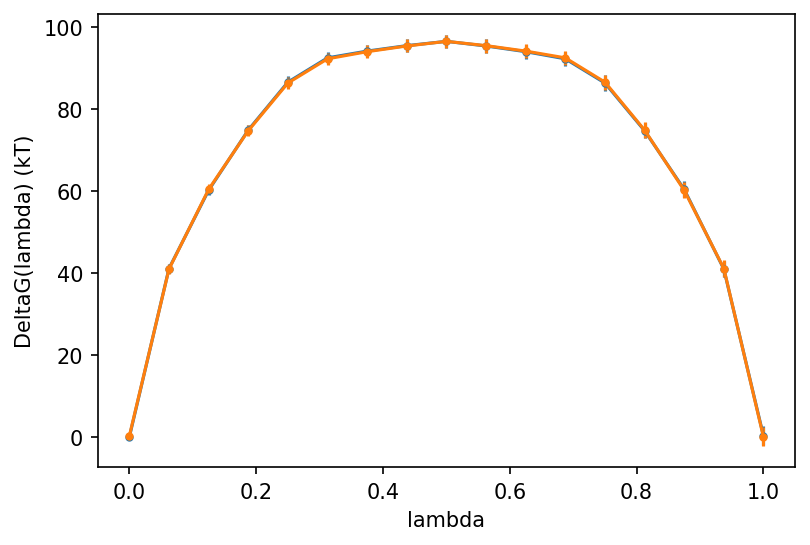

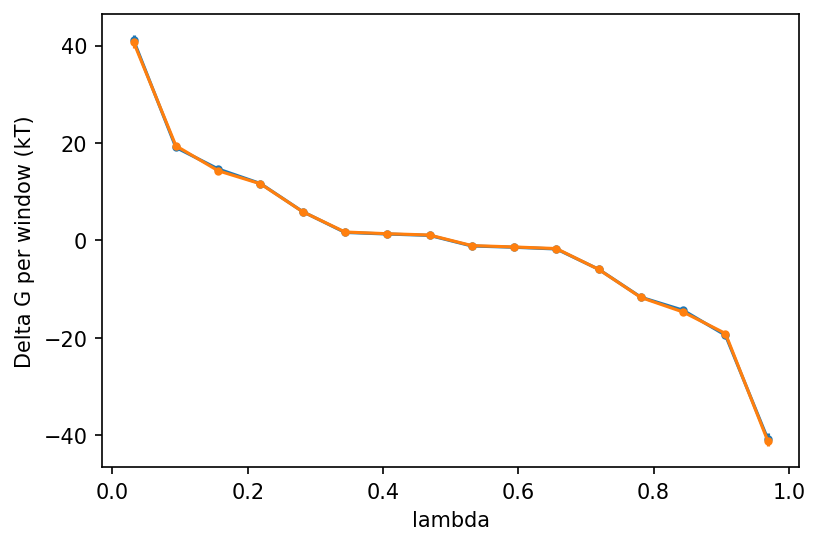

In [13]:
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.show()

plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.show()

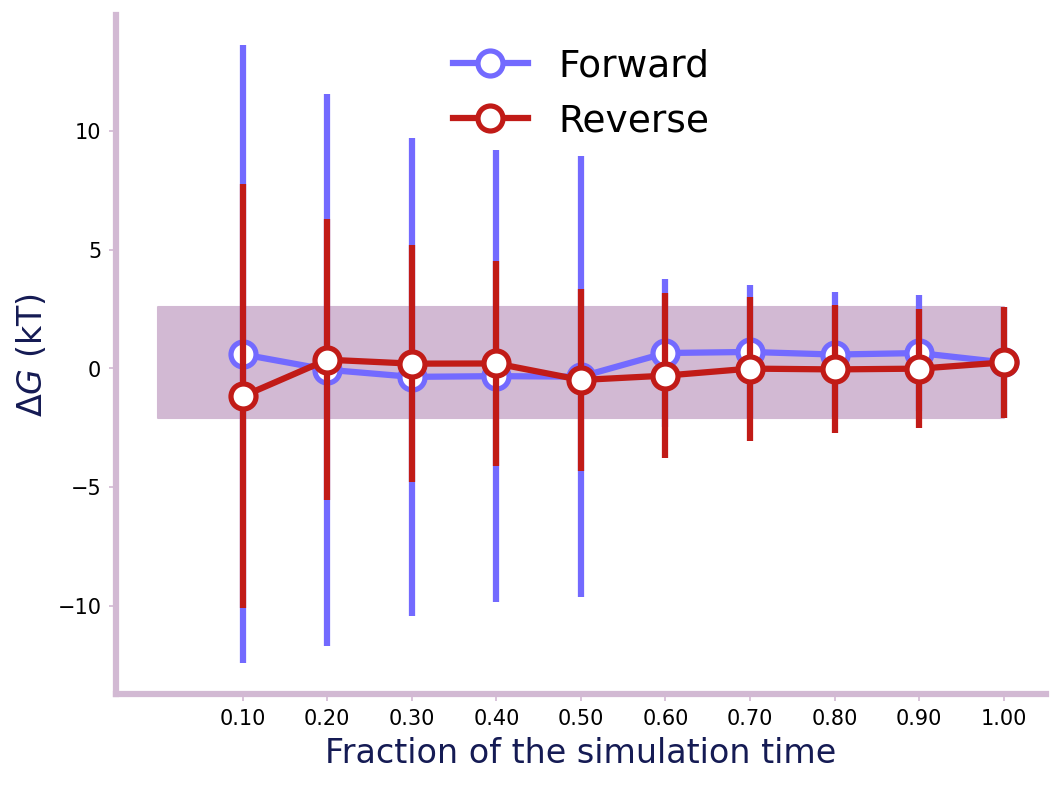

In [8]:
grouped = u_nk.groupby('fep-lambda')
data_list = [grouped.get_group(s) for s in states]

forward = []
forward_error = []
backward = []
backward_error = []
num_points = 10
for i in range(1, num_points+1):
    # forward
    partial = pd.concat([data[:int(len(data)/num_points*i)] for data in data_list])
    estimate = BAR().fit(partial)
    forward.append(estimate.delta_f_.iloc[0,-1])
    # For BAR, the error estimates are off-diagonal
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    forward_error.append(error)

    # backward
    partial = pd.concat([data[-int(len(data)/num_points*i):] for data in data_list])
    estimate = BAR().fit(partial)
    backward.append(estimate.delta_f_.iloc[0,-1])
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    backward_error.append(error)

from alchemlyb.visualisation import plot_convergence
ax = plot_convergence(forward, forward_error, backward, backward_error)
# ax.set_ylim(-40, -36)

In [9]:
#the data frame is organized from index level 1 (fep-lambda) TO column
#dG will be FROM column TO index
groups = u_nk.groupby(level=1)
dG=pd.DataFrame([])
for name, group in groups:
    dG[name] = np.log(np.mean(np.exp(-1*group)))

dG_f=np.diag(dG, k=1)
dG_b=np.diag(dG, k=-1)

l=dG.columns.to_list()
l_mid = np.mean([l[1:],l[:-1]], axis=0)

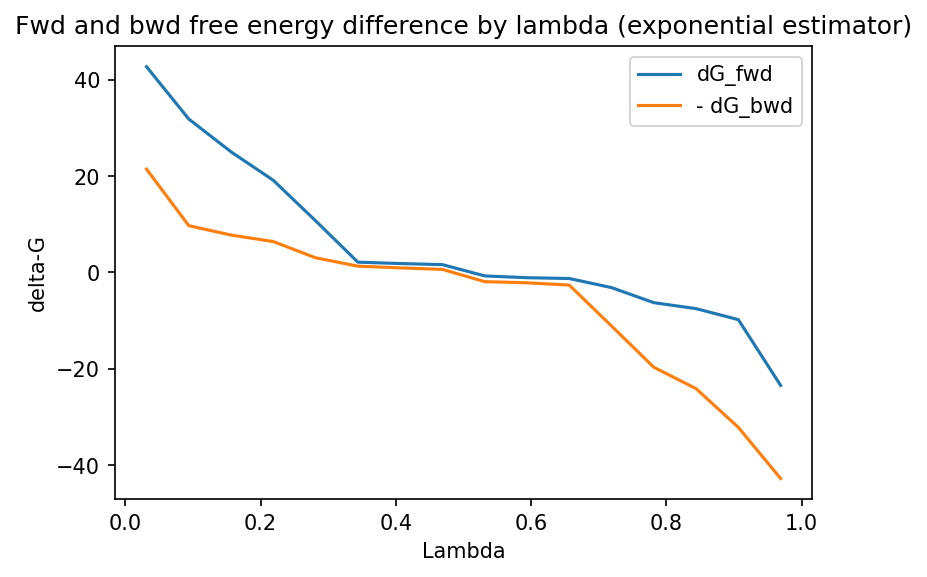

In [10]:
plt.plot(l_mid, dG_f, label='dG_fwd')
plt.plot(l_mid, -dG_b, label='- dG_bwd')

plt.title('Fwd and bwd free energy difference by lambda (exponential estimator)')
plt.xlabel('Lambda')
plt.ylabel('delta-G')
plt.legend()

Text(0, 0.5, 'Diff. in delta-G')

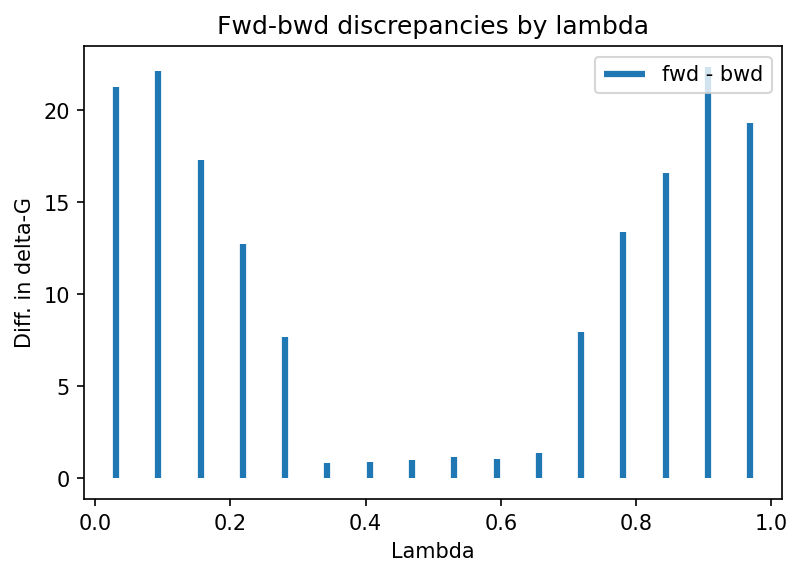

In [11]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=3)

plt.legend()
plt.title('Fwd-bwd discrepancies by lambda')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')

Text(0, 0.5, 'Count')

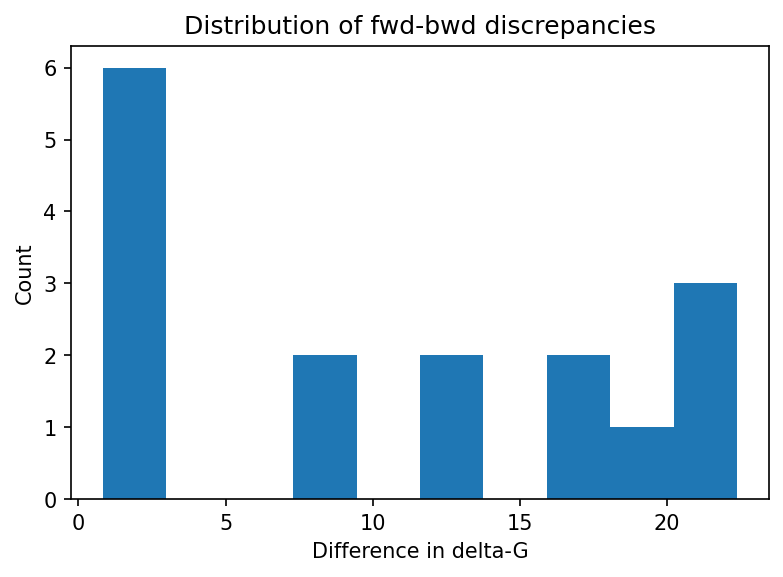

In [12]:
plt.hist(dG_f + np.array(dG_b));
plt.title('Distribution of fwd-bwd discrepancies')
plt.xlabel('Difference in delta-G')
plt.ylabel('Count')